In [2]:
import matplotlib.pyplot as plt
import numpy as np
import soundfile as sf
import sounddevice as sd
import scipy
import pickle
import librosa
%matplotlib qt5

In [22]:
# import everything
%run main.ipynb
fs = 44100

440.0
a
ba
[ba|440.0|1.0]


# VOCALOID

A software that takes musical notes + phonemes as input, and outputs a synthesized voice singing those notes.
- Most vocaloids use concatenative synthesis
- Another method: formant synthesis (rules-based synthesis)

In formant synthesis, output is generated by an acoustic model (in this case, LPC).
A "formant" refers to peaks in the spectrum, caused by resonances of the vocal tract. Outputs are typically less natural-sounding, but the model takes up significantly less space and resources.

There were a few main components to this project:
1. Vowel synthesis
2. Formant transitions
3. Natural vowel deviation
4. Consonants
5. Joining syllables

Since English has too many possible combinations of phonemes (consonants + vowels), I decided to work with the Japanese phonology.

## 1. Vowels
What differentiates vowels?


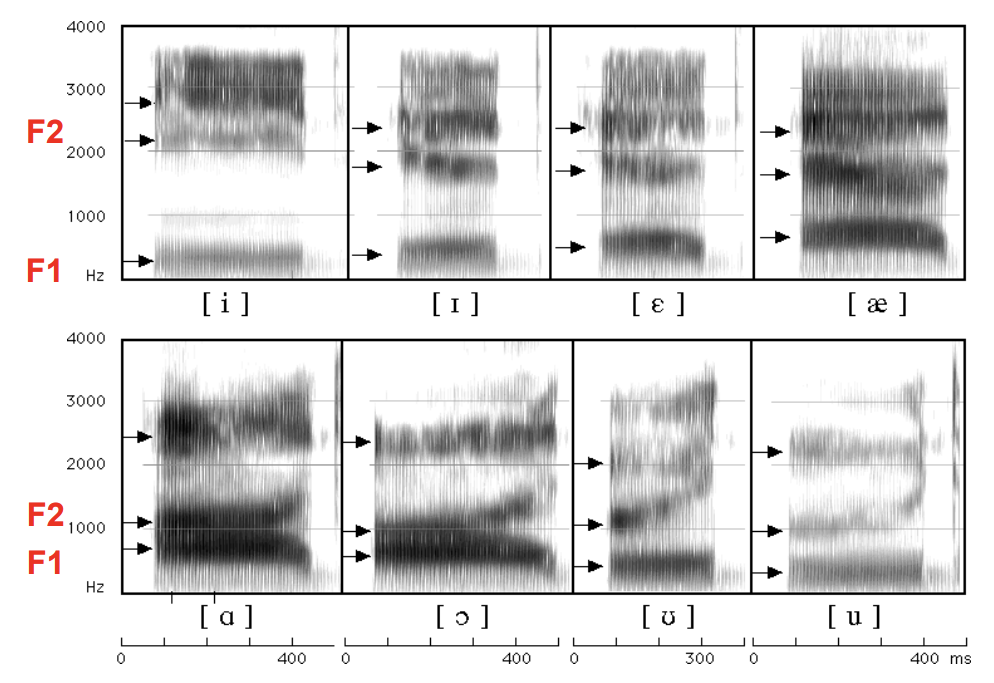
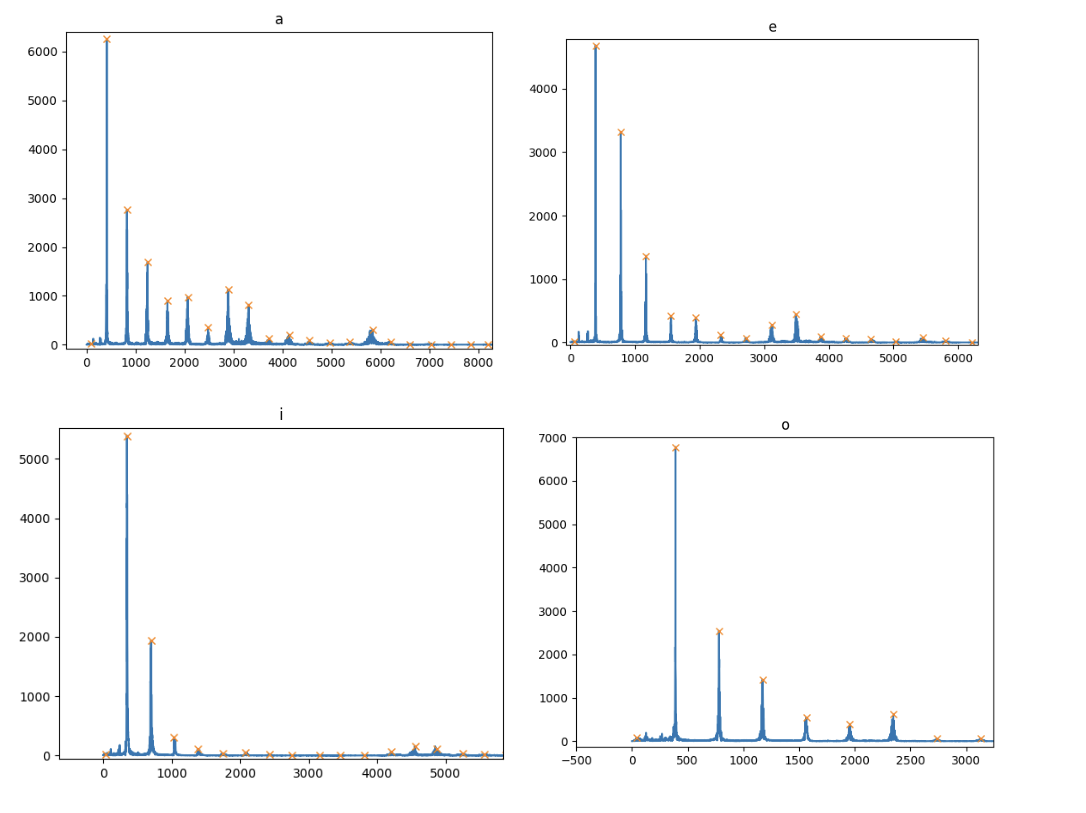

In [28]:
with open('vowel_harmonics_40', 'rb') as file:
    harms = pickle.load(file)

harmonic_magnitudes = harms['a']
harmonic_phases = np.zeros_like(harmonic_magnitudes)
y = simple_synth(174.61, harmonic_magnitudes, harmonic_phases, T=2.0, noise=0)
y = normalize(y, 0.8)
play_audio(y)
graph_signal(y)

### Better: LPC (Linear Predictive Coding)
Vowel sounds can be modeled by a glottal pulse, which is filtered by your vocal tract.

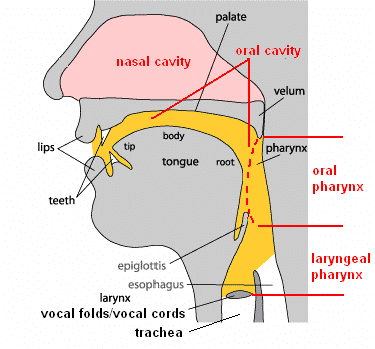 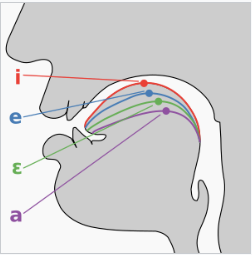

How do you find the coefficients of the filter? LPC algorithm does this!

In [31]:
y = glottal_pulse_simple(174.61, T=2.0)
y = normalize(y, 0.8)
graph_signal(y)
play_audio(y)

In [38]:
vowel = 'a'
y = read_audio(f"samples/vowel/{vowel}")
y = y[:,0] # convert to mono
# Compute LPC coefficients!
lpc_coeffs = librosa.lpc(y, order=order)

y_synthesized = glottal_filter(lpc_coeffs, f0, T=1.0, noise=0.008, slide=FormantSlide(100, 1.0, 1.0))  # ignore FormantSlide for now
y_synthesized = normalize(y_synthesized, 0.8)
play_audio(y_synthesized)
graph_signal(y_synthesized)



## 2. Formant Transitions
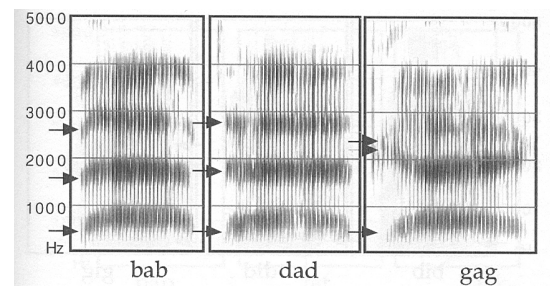 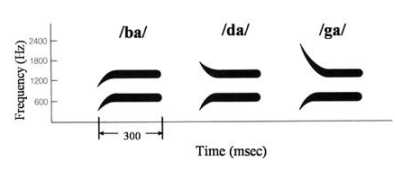

The pitch of each formant changes depending on the preceding and succeeding phoneme. How can we "pitch slide" different regions of the spectrum?

In [48]:
# example
y = np.zeros(80000)
interval = 200
offset = 100
pulse = 0
while pulse < 80000:
    y[pulse] = 0.8
    pulse += offset + interval
    if offset > 0:
        offset -= 4

graph_signal(y)
play_audio(y)


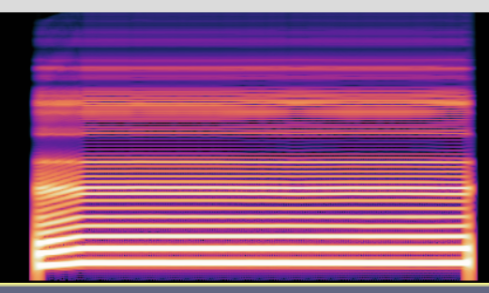

But how do we make different formants slide differently? We use the fourier approximation of the glottal pulse:
$$ \text{glottal\_pulse}(x) = \sum_{i = 1}^\infty \cos(f_0 \cdot i \cdot x)$$
Then, we can dilate different harmonics with different factors. We can smoothly change the period of a sinusoid $\cos(cx)$ by smoothly changing $c$.

In [ ]:
# use fourier approximation of glottal pulse
y = glottal_pulse(174.61, T=2.0, slide=FormantSlide(formant_thresh=1000, low_slide_start=0.7, high_slide_start=1.2, low_slide_T = 0.1, high_slide_T=0.1))
y = normalize(y, 0.8)
graph_signal(y)
play_audio(y)

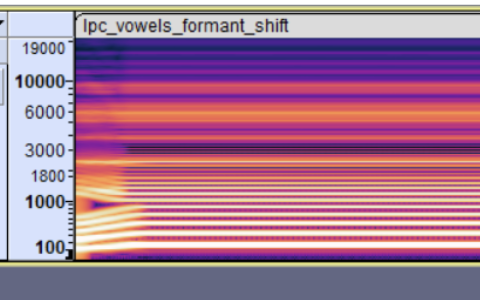

## 3. Natural Vowel Deviation
Most singers aren't perfect. There will be deviations in frequency and volume.

We can use Brownian Noise (integrated white noise) to simulate this. For frequency fluctuations, we can slightly fluctuate the distance between "peaks", and for volume fluctuations (tremolo), we simply multiply the signal by a random value.

In [84]:
# example of heavy frequency fluctuation. Sounds like groaning
# More natural value: 0.012
y = glottal_filter(lpc_coeffs, 174.61, T=2.0, noise=0.012)
y = normalize(y, 0.8)
play_audio(y)
graph_signal(y)

In [88]:
# add volume fluctuation
tremolo = 0.25
brown_noise = gen_brown_noise(len(y))
# upscale the noise so it is slower
brown_noise = scipy.signal.resample(brown_noise, 3 * len(y))[0:len(y)] 
# center around 1
brown_noise = brown_noise * tremolo + 1

play_audio(y * brown_noise)
graph_signal(y * brown_noise)

Finally, vowels aren't purely periodic. There is still some "airy-ness" to vowels, which is aperiodic and random. It can be modelled by LPC, but with Gaussian noise as the source (instead of a pulse)

In [ ]:
y_air = read_audio(f"samples/vowel/a_air")
y_air = y_air[:,0]
lpc_coeffs_air = librosa.lpc(y_air, order=order)
y_air_synthesized = noise_filter(lpc_coeffs_air, T=2.0, magnitude=0.0005)

y = (y + y_air_synthesized) * brown_noise
play_audio(y)
graph_signal(y)

## 4. Consonants
There are many different types of consonants, all of which are synthesized differently.

### 4.1 Voiceless Fricatives (s, h) and Voiced Fricatives (z)
Voiceless referes to no periodicity. Since voiceless fricatives do not depend on pitch, they are almost always pronounced the same, and so a single sample can simply be re-used.

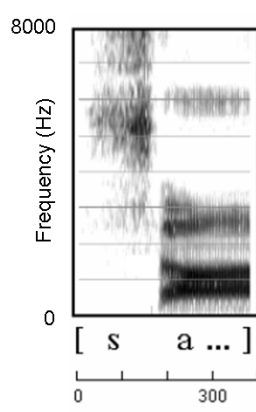

Note the gap between the end of the "s" and the start of the "a".


In [220]:
# re-import everything
%run main.ipynb

# make a "sa" sound
y = gen_syllable('s', 'a', f0=174.61, T=1.0)
play_audio(y)

There are also voiced fricatives, such as 'v' and 'z'. These are similar to voiceless fricatives, but the aperiodic noise is mixed with periodic signal.

In [134]:
# make a "zo" sound
y = gen_syllable('z', 'o', f0=174.61, T=1.0)
play_audio(y)

## 4.2 Voiceless Stops (p, t, k) and Voiced Stops (g, b, d)
Voiceless stops also (mostly) do not depend on pitch, so they can be sample-based.

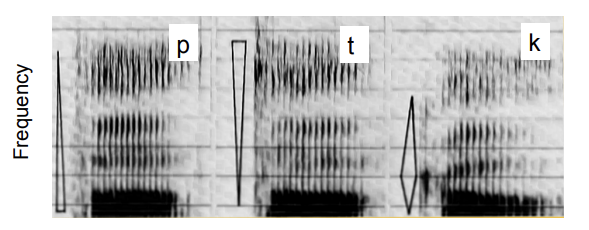

In [136]:
# make a "pu" sound
y = gen_syllable('p', 'u', f0=174.61, T=1.0)
play_audio(y)

Voiced stops are a bit more difficult; they have a "voice bar" that occurs between the stop and the vowel. These are weak, low frequency vibrations due to the closing of the vocal tract.

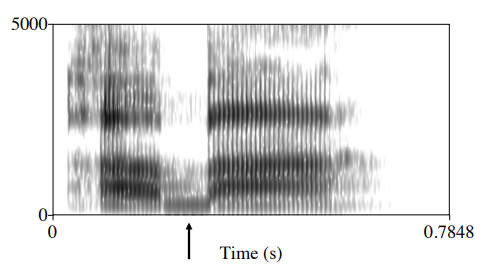

We can simulate the voice bar by putting a low pass filter on the start of the vowel, and smoothly transitioning back to the original vowel.

Note that formant transitions are also very important for voiced stops (especially g). Without them, they can be indistinguishable.

In [145]:
# make a "ga" sound
y = gen_syllable('g', 'a', f0=174.61, T=1.0)
play_audio(y)

## 4.3 Nasals (m, n) and Approximants (w, j, r)
Nasals and approximants are all voiced consonants, with little aperiodic noise. So, we can again use LPC to model them. Again, formant transitions are needed.

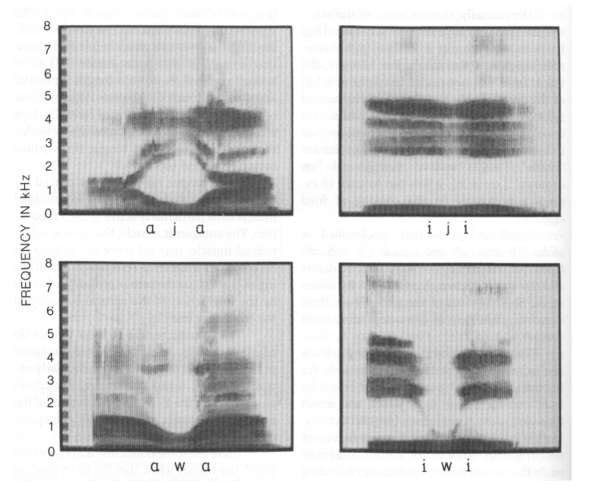

In [ ]:
# make a "ri" sound
y = gen_syllable('r', 'i', f0=174.61, T=1.0)
play_audio(y)

In [161]:
# make a "mu" sound
y = gen_syllable('m', 'u', f0=174.61, T=1.0)
play_audio(y)

# 5. Joining Syllables
Just like how the sound of a vowel depends on the preceding consonant, the sound of a consonant can depend on the preceding consonant/vowel, etc. There are too many possibilities to cover in this project, but a few that I implemented are:
- A vowel followed by a stop gets "blocked off"
- A vowel followed by a vowel is smoothly blended
- (Heuristic) a consonant followed by a consonant requires a small gap in between

# Extras: Serial input format
(show examples)

In [209]:
def gen_from_file(filename):
    notes = convert_from_file(f"input/{filename}.txt")
    y = generate_notes(notes)
    y = y/max(y)
    play_audio(y)
    # write_audio(y, f"output/{filename}")

gen_from_file("vowels")

In [224]:
gen_from_file("mary")
# no l's; had to use r's

In [229]:
gen_from_file("september")

In [225]:
gen_from_file("tonight")
# can you guess the song?

In [226]:
y = read_audio('output/meme')
play_audio(y)

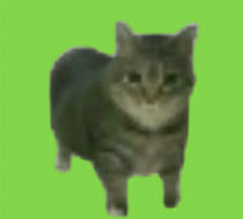

In [227]:
y = read_audio('senbonzakura(edited)')
play_audio(y)

# Conclusion + Next Steps
Creating a "good" vocaloid is very hard :(. As is, this vocaloid can serve as a vocal instrument, but is not comprehensible enough to serve as lead vocals.

With LPC synthesis and basic formant transformation, we can create comprehensible syllables. However, when strung together, these syllables sound clunky and aren't smoothly transitioned. 

There are a lot of resources online about synthesizing speech, but not about synthesizing singing. From my own experiments, formant transitions and envelopes differ between speech and song. Furthermore, singing has the added dimension of pitch, and (I would assume) the vocal tract behaves differently when singing different pitches, even if the exact same syllable; there wasn't much I could find online about this.

Next steps:
- Adjustable volume envelope per note
- Adjustable formant envelope per note
- Work on blending the end of a syllable with the start of the next (a lot of casework)


Image sources:
- https://en.wikipedia.org/wiki/Vowel
- http://www.lel.ed.ac.uk/~jkirby/hanoi/slides/lecture13-hanoi-4up.pdf
- http://www.lel.ed.ac.uk/~jkirby/hanoi/slides/lecture14-hanoi-4up.pdf 
- http://www.lel.ed.ac.uk/~jkirby/hanoi/slides/lecture15-hanoi-4up.pdf
